# Use Case - Churn Prediction

> Data Mining for Business Analytics ADS-505
>
> Fatemeh Khosravi - Stephen Kuc - Ruddy Simonpour

In [398]:
# import dependencies
import pandas as pd
import numpy as np
import csv
import os
import matplotlib.pylab as plt
import seaborn as sns

import statsmodels.tools.tools as stattools

from sklearn import preprocessing

# models
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB


from dmba.metric import AIC_score

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from dmba.metric import AIC_score
from dmba import classificationSummary, gainsChart, liftChart
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.svm import SVC
import sklearn.metrics as metrics

In [202]:
bank = pd.read_csv("Bank Customer Churn Prediction.csv",low_memory=False)

In [203]:
# print data
bank.sample(10)

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
3583,15773221,577,Spain,Male,43,8,79757.21,1,1,0,135650.72,1
6348,15707505,699,Spain,Male,31,8,125927.51,2,1,0,147661.47,0
6008,15700937,767,Spain,Female,24,5,0.00,2,1,1,67445.85,0
813,15775306,421,Germany,Male,28,8,122384.22,3,1,1,89017.38,1
2438,15792525,628,Germany,Female,61,1,97361.66,1,1,1,149922.38,1
5585,15656597,432,Germany,Male,38,2,135559.80,2,1,1,71856.30,0
6201,15753079,612,France,Male,41,5,0.00,3,0,0,151256.22,0
8723,15803202,350,France,Male,51,10,0.00,1,1,1,125823.79,1
7794,15714883,508,France,Female,25,2,111395.53,1,0,1,48197.06,0
8439,15692931,670,France,Male,22,2,114991.45,1,1,1,37392.56,0


In [204]:
# checking the data types
bank.dtypes

customer_id           int64
credit_score          int64
country              object
gender               object
age                   int64
tenure                int64
balance             float64
products_number       int64
credit_card           int64
active_member         int64
estimated_salary    float64
churn                 int64
dtype: object

In [205]:
# dataframe shape
print(f'Number of rows in the dataframe {bank.shape[0]}')
print(f'Number of columns in the dataframe {bank.shape[1]}')

Number of rows in the dataframe 10000
Number of columns in the dataframe 12


In [206]:
bank.describe().T

,count,mean,std,min,25%,50%,75%,max
customer_id,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
credit_score,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
tenure,10000.0,5.012800e+00,2.892174,0.00,3.00,5.000000e+00,7.000000e+00,10.00
balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
products_number,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
credit_card,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
active_member,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
estimated_salary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48
churn,10000.0,2.037000e-01,0.402769,0.00,0.00,0.000000e+00,0.000000e+00,1.00


For binary variables, incl target:

Churn: ~20.4% positive records CC: ~70.5% positive active member: ~51.5% positive

For numerical:

cc: seems about symmetrical (median ~= mean); ranges from 350 - 850

age: 18 - 92; slightly skewed right, with mean of 38.9 and median of 37.

tenure: seems symmetrical; anywhere from 0 years to 10 years.

balance: ranges from  0𝑡𝑜 250k. The median > mean (~97k vs 76k), so it is skewed left

estimated salary: mean / median both around 100k. ranges from 57.5k to ~200k.

### Missing values

In [207]:
# checking for missing values
bank.isnull().sum()

customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

There is no missing values in the dataset

### Duplicated Rows

In [208]:
# checking for duplicated values
duplicate_values = bank.duplicated().sum()
print(f'The number of duplicated values are : {duplicate_values}')

The number of duplicated values are : 0


In [209]:
# check number of unique values for each column
bank.nunique()

customer_id         10000
credit_score          460
country                 3
gender                  2
age                    70
tenure                 11
balance              6382
products_number         4
credit_card             2
active_member           2
estimated_salary     9999
churn                   2
dtype: int64

There are only 3 different countries and 4 different products. These two we can make into dummy variables. CC and active member are indeed binary. 

### Visualization

<AxesSubplot:>

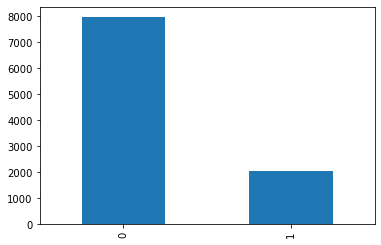

In [210]:
bank["churn"].value_counts().plot(kind="bar")

In [211]:
bank["products_number"].value_counts()

1    5084
2    4590
3     266
4      60
Name: products_number, dtype: int64

The target variable is not balance

### Dummy Variables

There is not missing values and duplicated values in the dataset. Now we can drop unnecessary columns. "Customer-ID"s are assigned at random and are not based on anything. Therefore, we can remove this column

In [212]:
bank_country = pd.get_dummies(bank['country'], prefix = 'country', drop_first = True)
bank_gender= pd.get_dummies(bank['gender'], prefix = 'gender', drop_first = True)

churn_df = bank.drop(['country', 'gender', 'customer_id'], axis = 1)

churn_df = pd.concat([churn_df, bank_country, bank_gender], axis = 1)

churn_df.head()

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,country_Germany,country_Spain,gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


In [213]:
# change the data type of the dummy variables (uint8 --> int64)
def data_type_change(df,cols):
    df[cols]=df[cols].astype(int)
    return df

churn_df = data_type_change(churn_df,["country_Germany","country_Spain",
                                      "gender_Male"])

churn_df.dtypes

credit_score          int64
age                   int64
tenure                int64
balance             float64
products_number       int64
credit_card           int64
active_member         int64
estimated_salary    float64
churn                 int64
country_Germany       int64
country_Spain         int64
gender_Male           int64
dtype: object

### Correlation

<AxesSubplot:>

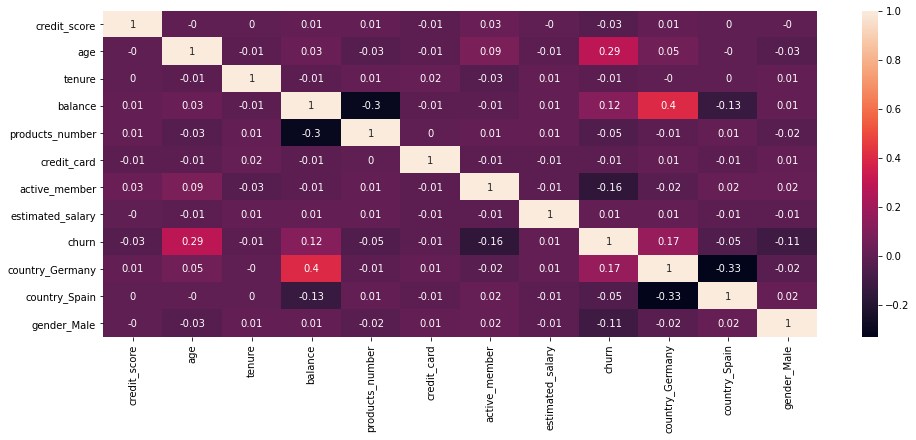

In [214]:
# Correlation matrix
plt.figure(figsize=(16, 6))
sns.heatmap(round(churn_df.corr(),2), annot = True)

highest correlations with churn: age (+.29), country_germany (+.17)

Multi collinearities?

Age -- no, next highest correlation is .09 with active member.

country_Germany -- .4 with balance; -.33 with country_Spain

### Distribution of Numerical Variables

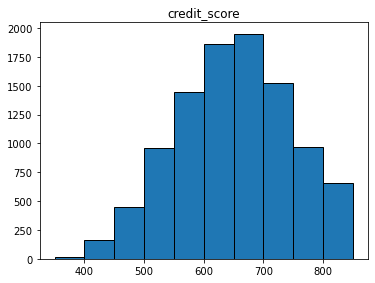

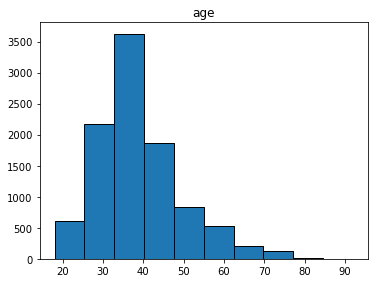

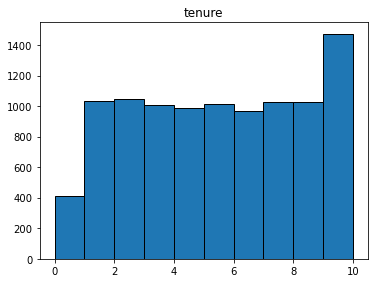

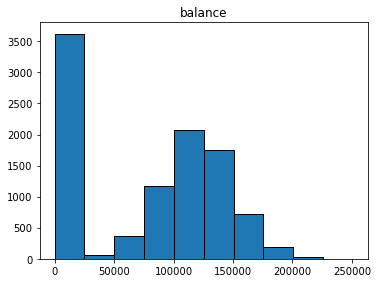

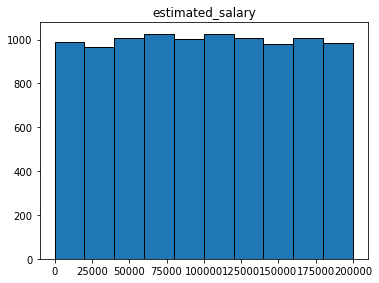

In [215]:
# Visualizing each numerical variables histogram
col=churn_df[['credit_score','age','tenure','balance','estimated_salary']]
for i in col:
  n=1
  plt.figure(figsize=(20,20))
  plt.subplot(4,3,1)
  plt.hist(churn_df[i],edgecolor='black')
  plt.title(i)
  plt.show()
  n=n+1

###  Skewness

In [216]:
# check the skewness
col=churn_df[['credit_score','age','tenure','balance','estimated_salary']]
col.skew()

credit_score       -0.071607
age                 1.011320
tenure              0.010991
balance            -0.141109
estimated_salary    0.002085
dtype: float64

### Log Transformation

Text(0.5, 1.0, 'Log Transformed Age')

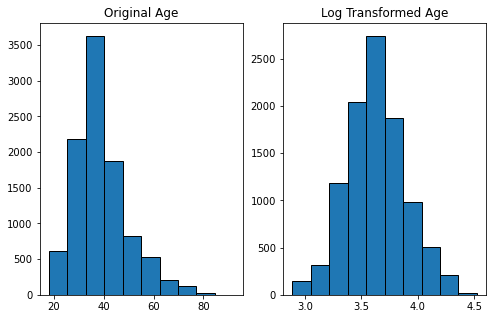

In [217]:
# log transformation for age 
np.random.seed(0)
age_trans = np.log(churn_df['age'])
fig, axs = plt.subplots(nrows=1, ncols=2,figsize=(8,5))
axs[0].hist(churn_df['age'], edgecolor='black')
axs[1].hist(age_trans, edgecolor='black')
axs[0].set_title('Original Age')
axs[1].set_title('Log Transformed Age')

In [218]:
# converting  skewed column to the transformed values
churn_df['age']=age_trans

### Scaling

In [219]:
# for scaling any numerical 

churn_numerical = churn_df[['credit_score','age', 'tenure','balance', 'estimated_salary']]


from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(churn_numerical)

churn_numerical_scaled = scaler.transform(churn_numerical)

churn_numerical_scaled = pd.DataFrame(churn_numerical_scaled, columns = churn_numerical.columns)

churn_numerical_scaled.head()

,credit_score,age,tenure,balance,estimated_salary
0,-0.326221,0.425883,-1.041760,-1.225848,0.021886
1,-0.440036,0.332621,-1.387538,0.117350,0.216534
2,-1.536794,0.425883,1.032908,1.333053,0.240687
3,0.501521,0.139072,-1.387538,-1.225848,-0.108918
4,2.063884,0.516950,-1.041760,0.785728,-0.365276


In [220]:
# We can add these back into the

churn_df_scaled = churn_df.drop(churn_numerical, axis =1)

churn_df_scaled = pd.concat([churn_df_scaled, churn_numerical_scaled], axis = 1)

churn_df_scaled.head(5)

,products_number,credit_card,active_member,churn,country_Germany,country_Spain,gender_Male,credit_score,age,tenure,balance,estimated_salary
0,1,1,1,1,0,0,0,-0.326221,0.425883,-1.041760,-1.225848,0.021886
1,1,0,1,0,0,1,0,-0.440036,0.332621,-1.387538,0.117350,0.216534
2,3,1,0,1,0,0,0,-1.536794,0.425883,1.032908,1.333053,0.240687
3,2,0,0,0,0,0,0,0.501521,0.139072,-1.387538,-1.225848,-0.108918
4,1,1,1,0,0,1,0,2.063884,0.516950,-1.041760,0.785728,-0.365276


### Outliers

/Users/fatemehkhosravi/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/fatemehkhosravi/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/fatemehkhosravi/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or m

<AxesSubplot:xlabel='estimated_salary'>

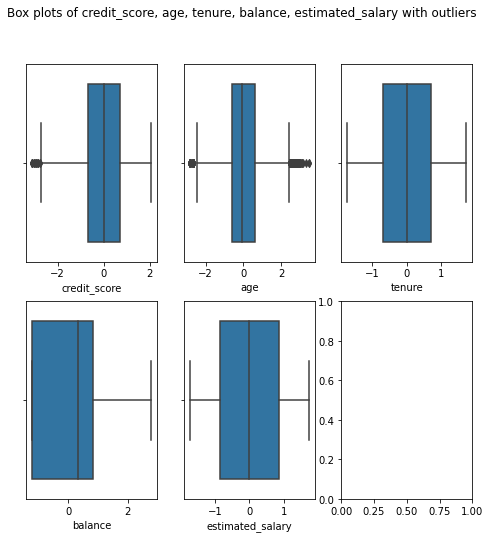

In [221]:
fig, axes = plt.subplots(2,3, figsize=(8,8))
plt.suptitle('Box plots of credit_score, age, tenure, balance, estimated_salary with outliers')

sns.boxplot(churn_df_scaled['credit_score'],ax=axes[0,0])
sns.boxplot(churn_df_scaled['age'],ax=axes[0,1])
sns.boxplot(churn_df_scaled['tenure'],ax=axes[0,2])
sns.boxplot(churn_df_scaled['balance'],ax=axes[1,0])
sns.boxplot(churn_df_scaled['estimated_salary'],ax=axes[1,1])

In [222]:
#Boxplot WITH outliers
numeric_columns= ['credit_score','age','tenure','balance','estimated_salary']
for col_name in numeric_columns:
  print('feature: ', col_name)
  

  #IQR
  Q1 = churn_df_scaled[col_name].quantile(0.25)
  Q3 = churn_df_scaled[col_name].quantile(0.75)
  IQR = Q3-Q1

  mean1 = round(churn_df_scaled[col_name].mean(),2)
  std1 = round(churn_df_scaled[col_name].std(),2)
  median1 = round(churn_df_scaled[col_name].median(),2)
  churn_df_scaled = churn_df_scaled[(churn_df_scaled[col_name] > (Q1 - 1.5 * IQR)) & (churn_df_scaled[col_name] < (Q3 + 1.5 * IQR))]

feature:  credit_score
feature:  age
feature:  tenure
feature:  balance
feature:  estimated_salary


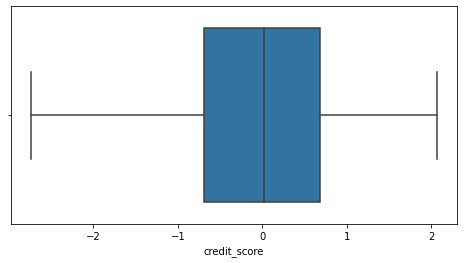

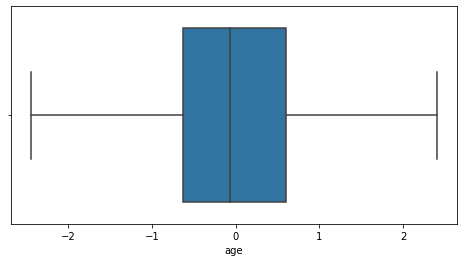

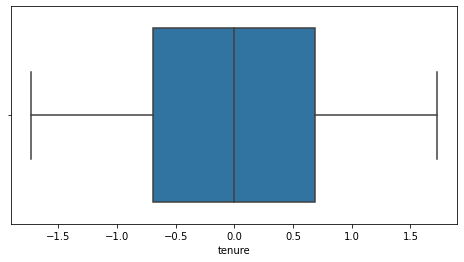

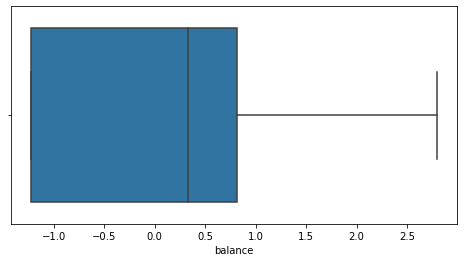

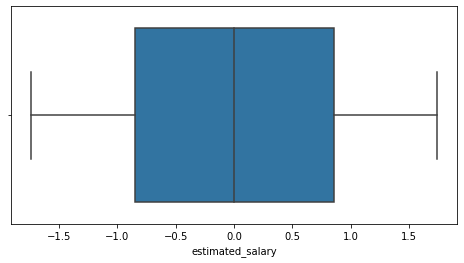

In [223]:
#Boxplot WITHOUT outliers
numeric_columns= ['credit_score','age','tenure','balance','estimated_salary'] 
for col_name in numeric_columns:
  plt.figure(figsize = (8,4))
  sns.boxplot(x = churn_df_scaled[col_name])

In [224]:
churn_df_scaled.shape

(9802, 12)

The number of 198 samples were removed from the data.

### Imbalance dataset

In [238]:
churn_df_scaled['churn'].value_counts()/churn_df_scaled.shape[0]

0    0.795246
1    0.204754
Name: churn, dtype: float64

In [229]:
# splitting into X and Y

X = churn_df_scaled.drop('churn', axis = 1)
y =churn_df_scaled['churn']

In [230]:
churn_df_scaled['churn'].value_counts()

0    7795
1    2007
Name: churn, dtype: int64

### SMOTE
!pip install imbalanced-learn

In [231]:
smote = SMOTE(sampling_strategy='minority',random_state=0)
X_smt, y_smt = smote.fit_resample(X,y)

y_smt.value_counts()

1    7795
0    7795
Name: churn, dtype: int64

### Train-Test Spliting

In [232]:
# partitioning data into 90% train and 10% test, and then will further split for validation

trainX, testX, trainy, testy = train_test_split(X_smt, y_smt, test_size = .1, random_state = 12345)

# using 80 / 20 split for train and validation set

trainX, validX, trainy, validy = train_test_split(trainX, trainy, test_size = .2, random_state = 12345)

In [233]:
print("Test set dimensions: ", testX.shape, 
      "\n Train set dimensions: ", trainX.shape,
      "\n Validation set dimension: ", validX.shape)

Test set dimensions:  (1559, 11) 
 Train set dimensions:  (11224, 11) 
 Validation set dimension:  (2807, 11)


## Modeling

### K-NN

In [241]:
# Train a classifier for different values of k
knn_results = []
for k in range(1, 25, 2):
    knn = KNeighborsClassifier(n_neighbors=k).fit(trainX, trainy)
    knn_results.append({
        'k': k,
        'accuracy': accuracy_score(validy, knn.predict(validX)),
        'recall': recall_score(validy, knn.predict(validX)),
        'f1_score': f1_score(validy, knn.predict(validX))
    })

# Convert results to a pandas data frame
knn_results = pd.DataFrame(knn_results)
knn_results

,k,accuracy,recall,f1_score
0,1,0.878874,0.946676,0.889395
1,3,0.862487,0.934211,0.874838
2,5,0.855362,0.918283,0.867233
3,7,0.848949,0.909280,0.860984
4,9,0.841112,0.896814,0.853096
5,11,0.836836,0.880886,0.847435
6,13,0.832561,0.880194,0.843958
7,15,0.833274,0.877424,0.844104
8,17,0.827574,0.863573,0.837475
9,19,0.821874,0.860111,0.832440


Text(0, 0.5, 'Metrics score')

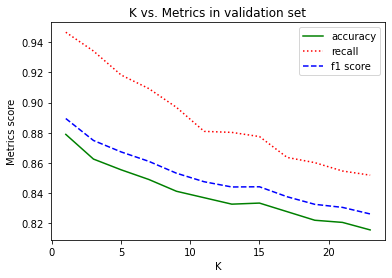

In [244]:
# Plotting K-nn metrics from validation tests

# show accuracy by k
plt.plot(knn_results.k, knn_results.accuracy, linestyle='-', c='green', label = "accuracy")
plt.plot(knn_results.k, knn_results.recall, linestyle=':', c='red', label = "recall")
plt.plot(knn_results.k, knn_results['f1_score'], linestyle='--', c='blue', label = "f1 score")
plt.legend()
plt.title('K vs. Metrics in validation set')
plt.xlabel('K')
plt.ylabel('Metrics score')

In [299]:
# knn and tuning hyperparameters 

grid_parameters = [{
    'n_neighbors': list(range(1,31,1)),
    }]



Knn=GridSearchCV(KNeighborsClassifier(),grid_parameters, cv=5, scoring='accuracy', return_train_score=False,verbose=1)
Knn.fit(trainX, trainy)
knn_clf = Knn_clf.best_estimator_


Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [300]:
#best parameters for KNN classifier
Knn.best_params_


{'n_neighbors': 1}

In [351]:
 # predictive performance on training data 
classificationSummary(trainy, knn_clf.predict(trainX))


Confusion Matrix (Accuracy 1.0000)

       Prediction
Actual    0    1
     0 5665    0
     1    0 5559


[[1100  263]
 [  77 1367]]
              precision    recall  f1-score   support

           0       0.93      0.81      0.87      1363
           1       0.84      0.95      0.89      1444

    accuracy                           0.88      2807
   macro avg       0.89      0.88      0.88      2807
weighted avg       0.89      0.88      0.88      2807



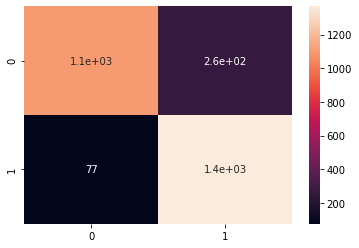

In [352]:
#Confusion matrix
cm=confusion_matrix(validy,knn_clf.predict(validX))
print(cm)
sns.heatmap(cm,annot=True)

print(classification_report(validy,knn_clf.predict(validX)))

### Random Forest

In [316]:
# Train a classifier for different values of n_estimators
rf_results = []
for x in range(100, 1001, 100):
    rf = RandomForestClassifier(n_estimators = x, random_state = 1).fit(trainX, trainy)
    rf_results.append({'n_estimators': x, 'accuracy': accuracy_score(validy, rf.predict(validX)), 
                      'precision': precision_score(validy, rf.predict(validX)),
                      'f1_score': f1_score(validy, rf.predict(validX))})

    
# Convert results to a pandas data frame
rf_results = pd.DataFrame(rf_results)

Text(0, 0.5, 'Metrics score')

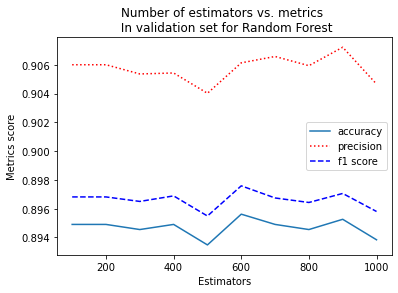

In [319]:
# show accuracy by estimators
plt.plot(rf_results['n_estimators'], rf_results.accuracy, linestyle='-', label = "accuracy")
plt.plot(rf_results['n_estimators'], rf_results.precision, linestyle=':', c='red', label = "precision")
plt.plot(rf_results['n_estimators'], rf_results['f1_score'], linestyle='--', c='blue', label = "f1 score")
plt.title('Number of estimators vs. metrics \n In validation set for Random Forest')
plt.legend()
plt.xlabel('Estimators')
plt.ylabel('Metrics score')

In [304]:
# random forest tuning hyperparameters 

grid_parameters = { 
    'n_estimators': [100,200,300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}


rf= GridSearchCV(RandomForestClassifier(random_state=42), grid_parameters, cv= 5)
rf=rf.fit(trainX, trainy)
rf_clf=rf.best_estimator_


In [305]:
#best parameters for random forest classifier
rf.best_params_


{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 300}

In [353]:
 # predictive performance on training data 
classificationSummary(trainy, rf_clf.predict(trainX))

Confusion Matrix (Accuracy 0.8508)

       Prediction
Actual    0    1
     0 4953  712
     1  963 4596


[[1182  181]
 [ 305 1139]]
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1363
           1       0.86      0.79      0.82      1444

    accuracy                           0.83      2807
   macro avg       0.83      0.83      0.83      2807
weighted avg       0.83      0.83      0.83      2807



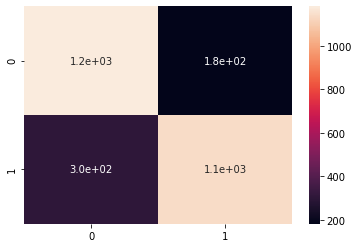

In [354]:
#Confusion matrix
cm=confusion_matrix(validy,rf_clf.predict(validX))
print(cm)
sns.heatmap(cm,annot=True)

print(classification_report(validy,rf_clf.predict(validX)))

### Decision Tree

In [324]:
dt_results = []
criterion = ["gini", "entropy"]

for x in criterion:
    dt = DecisionTreeClassifier(criterion = x, random_state = 1).fit(trainX, trainy)
    dt_results.append({'criterion': x, 'accuracy': accuracy_score(validy, dt.predict(validX)), 
                      'precision': precision_score(validy, dt.predict(validX)),
                      'f1_score': f1_score(validy, dt.predict(validX))})
    

# Convert results to a pandas data frame
dt_results = pd.DataFrame(dt_results)

In [325]:
dt_results.sort_values(by=["accuracy"],ascending=False)

,criterion,accuracy,precision,f1_score
0,gini,0.820449,0.819293,0.827160
1,entropy,0.820093,0.830401,0.823735


In [326]:
dt_results_depth = []

for x in range(2, 30, 2):
    dt = DecisionTreeClassifier(max_depth = x, criterion = "entropy", random_state = 1).fit(trainX, trainy)
    dt_results_depth.append({'max_depth': x, 'accuracy': accuracy_score(validy, dt.predict(validX)), 
                      'precision': precision_score(validy, dt.predict(validX)),
                      'f1_score': f1_score(validy, dt.predict(validX))})
dt_results_depth = pd.DataFrame(dt_results_depth)

In [327]:
dt_results_depth

,max_depth,accuracy,precision,f1_score
0,2,0.732811,0.772370,0.724062
1,4,0.762024,0.742804,0.780408
2,6,0.791236,0.804255,0.794674
3,8,0.797292,0.834736,0.793166
4,10,0.796580,0.831939,0.793041
5,12,0.801211,0.820550,0.802548
6,14,0.799786,0.817723,0.801554
7,16,0.808693,0.818693,0.812696
8,18,0.815461,0.831662,0.817606
9,20,0.818311,0.833096,0.820801


Text(0, 0.5, 'Metrics score')

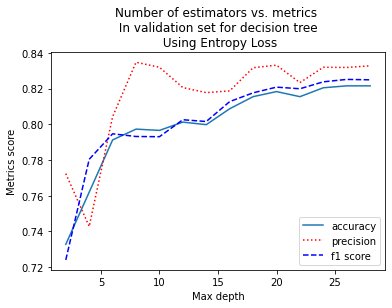

In [328]:
# show accuracy by depth
plt.plot(dt_results_depth['max_depth'], dt_results_depth.accuracy, linestyle='-', label = "accuracy")
plt.plot(dt_results_depth['max_depth'], dt_results_depth.precision, linestyle=':', c='red', label = "precision")
plt.plot(dt_results_depth['max_depth'], dt_results_depth['f1_score'], linestyle='--', c='blue', label = "f1 score")
plt.title('Number of estimators vs. metrics \n In validation set for decision tree \n Using Entropy Loss')
plt.legend()
plt.xlabel('Max depth')
plt.ylabel('Metrics score')

In [308]:
# decisin tree tuning hyperparameters

# initial guess for parameters
grid_parameters = {
    'max_depth': [10, 20, 30, 40],
    'min_samples_split': [20, 40, 60, 80, 100],
    'min_impurity_decrease': [0, 0.0005, 0.001, 0.005, 0.01],
}
tree = GridSearchCV(DecisionTreeClassifier(), grid_parameters, cv=5, n_jobs=-1)
tree.fit(trainX, trainy)
print('Initial score: ',tree.best_score_)
print('Initial parameters: ', tree.best_params_)



Initial score:  0.8061303590073404
Initial parameters:  {'max_depth': 40, 'min_impurity_decrease': 0, 'min_samples_split': 20}


In [310]:
# Adapt grid based on result from initial grid search
grid_parameters = {
    'max_depth': list(range(30, 50)),
    'min_samples_split': list(range(15, 30)),
    'min_impurity_decrease': [0, 0.001, 0.0011],
}
tree = GridSearchCV(DecisionTreeClassifier(), grid_parameters, cv=5, n_jobs=-1)
tree.fit(trainX, trainy)
print('Improved score: ',tree.best_score_)
print('Improved parameters: ', tree.best_params_)
tree_clf = tree.best_estimator_


Improved score:  0.8081795949803287
Improved parameters:  {'max_depth': 45, 'min_impurity_decrease': 0, 'min_samples_split': 17}


In [312]:
#best parameters for decision tree classifier
tree.best_params_

{'max_depth': 45, 'min_impurity_decrease': 0, 'min_samples_split': 17}

In [355]:
 # predictive performance on training data 
classificationSummary(trainy, tree_clf.predict(trainX))


Confusion Matrix (Accuracy 0.9264)

       Prediction
Actual    0    1
     0 5337  328
     1  498 5061


[[1152  211]
 [ 286 1158]]
              precision    recall  f1-score   support

           0       0.80      0.85      0.82      1363
           1       0.85      0.80      0.82      1444

    accuracy                           0.82      2807
   macro avg       0.82      0.82      0.82      2807
weighted avg       0.82      0.82      0.82      2807



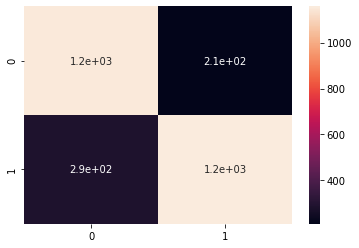

In [356]:
#Confusion matrix
cm=confusion_matrix(validy,tree_clf.predict(validX))
print(cm)
sns.heatmap(cm,annot=True)

print(classification_report(validy,tree_clf.predict(validX)))

### Logistic Regression

In [331]:
lr = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
lr.fit(trainX, trainy)

LogisticRegression(C=1e+42, solver='liblinear')

In [332]:
print('intercept ', lr.intercept_[0])
print(pd.DataFrame({'coeff': lr.coef_[0]}, index=X.columns).transpose())

print('AIC', AIC_score(validy, lr.predict(validX), df = len(trainX.columns) + 1))

intercept  1.0833621553645938
       products_number  credit_card  active_member  country_Germany  \
coeff        -0.306953    -0.173466       -1.22963         0.600088   

       country_Spain  gender_Male  credit_score       age   tenure   balance  \
coeff      -0.393587    -0.759888     -0.009186  1.053379 -0.03515  0.184553   

       estimated_salary  
coeff          0.011039  
AIC 4113.562643057266


Positive correlations for factors like age and country Germany are linked to increased odds of a client leaving the bank. On the other hand, variables with negative coefficients are linked to staying in the bank, including having a strong credit score, a high wage, being an active member, and having a high credit score.


In [345]:
#Logistic Regression and tuning hyperparameters 
grid_parameters = {'C': [0.0001,0.001,0.01,0.1, 0.5, 1, 5, 10, 50, 100]}
lr= GridSearchCV(LogisticRegression(solver='liblinear',random_state=42), 
                 grid_parameters, cv=5, scoring="accuracy")
lr.fit(trainX,trainy)
lr_clf=lr.best_estimator_

In [346]:
#best parameters for logistic regression classifier
lr.best_params_

{'C': 0.01}

In [350]:
 # predictive performance on training data 
classificationSummary(trainy, lr_clf.predict(trainX))


Confusion Matrix (Accuracy 0.7350)

       Prediction
Actual    0    1
     0 4211 1454
     1 1520 4039


[[1054  309]
 [ 401 1043]]
              precision    recall  f1-score   support

           0       0.72      0.77      0.75      1363
           1       0.77      0.72      0.75      1444

    accuracy                           0.75      2807
   macro avg       0.75      0.75      0.75      2807
weighted avg       0.75      0.75      0.75      2807



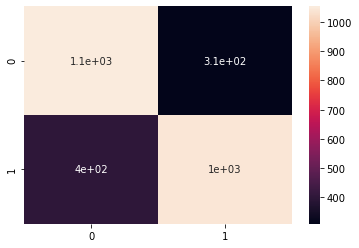

In [373]:
#Confusion matrix
cm=confusion_matrix(validy,lr_clf.predict(validX))
print(cm)
sns.heatmap(cm,annot=True)

print(classification_report(validy,lr_clf.predict(validX)))

### XGBoost

In [375]:
# xgb and tuning hyperparameters 

xgb = GridSearchCV(XGBClassifier(),{'max_depth': [2,4,6,8,10],
                    'n_estimators': [50,100,200,250]}, 
                    verbose=1, 
                    scoring='neg_log_loss')

xgb.fit(trainX,trainy)
xgb_clf=xgb.best_estimator_


Fitting 5 folds for each of 42 candidates, totalling 210 fits


/Users/fatemehkhosravi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2283: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/Users/fatemehkhosravi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2283: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/Users/fatemehkhosravi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2283: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/Users/fatemehkhosravi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2283: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/Users/fatemehkhosravi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2283: RuntimeWarning: divide

In [376]:
#best parameters for xgboost classifier
xgb.best_params_

{'max_depth': 6, 'n_estimators': 100}

In [377]:
 # predictive performance on training data 
classificationSummary(trainy, xgb_clf.predict(trainX))

Confusion Matrix (Accuracy 0.9658)

       Prediction
Actual    0    1
     0 5565  100
     1  284 5275


[[1272   91]
 [ 195 1249]]
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      1363
           1       0.93      0.86      0.90      1444

    accuracy                           0.90      2807
   macro avg       0.90      0.90      0.90      2807
weighted avg       0.90      0.90      0.90      2807



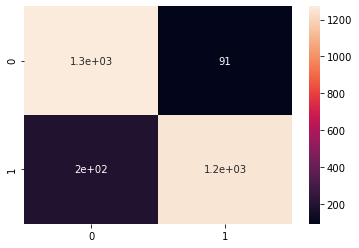

In [378]:
#Confusion matrix
cm=confusion_matrix(validy,xgb_clf.predict(validX))
print(cm)
sns.heatmap(cm,annot=True)

print(classification_report(validy,xgb_clf.predict(validX)))

### Support Vector machine (SVM)

In [400]:
# SVM and tuning hyperparameters 
grid_parameters = {'C': [ 0.1, 1, 10,12,15,20,25], 
          'gamma': [0.001, 0.01, 1,5,10]}

model = SVC()
svc= GridSearchCV(SVC(), grid_parameters)
svc.fit(trainX, trainy)
svc_clf=svc.best_estimator_

In [402]:
#best parameters for decision tree classifier
svc.best_params_

{'C': 20, 'gamma': 1}

In [403]:
 # predictive performance on training data 
classificationSummary(trainy, svc_clf.predict(trainX))

Confusion Matrix (Accuracy 0.9989)

       Prediction
Actual    0    1
     0 5656    9
     1    3 5556


[[1183  180]
 [ 111 1333]]
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      1363
           1       0.88      0.92      0.90      1444

    accuracy                           0.90      2807
   macro avg       0.90      0.90      0.90      2807
weighted avg       0.90      0.90      0.90      2807



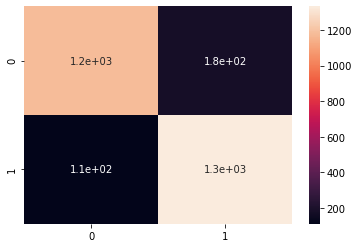

In [404]:
#Confusion matrix
cm=confusion_matrix(validy,svc_clf.predict(validX))
print(cm)
sns.heatmap(cm,annot=True)

print(classification_report(validy,svc_clf.predict(validX)))

## Testing the models on test data set

### K-NN

0.8794098781270044
[[616 151]
 [ 37 755]]
              precision    recall  f1-score   support

           0       0.94      0.80      0.87       767
           1       0.83      0.95      0.89       792

    accuracy                           0.88      1559
   macro avg       0.89      0.88      0.88      1559
weighted avg       0.89      0.88      0.88      1559



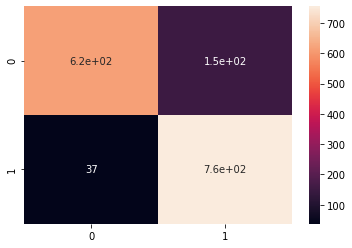

In [405]:
#test the model
test1=knn_clf.predict(testX)
print(accuracy_score(testy, test1))

#Confusion matrix
cm=confusion_matrix(testy,test1)
print(cm)
sns.heatmap(cm,annot=True)

print(classification_report(testy, test1))

### Random Forest

0.8139833226427197
[[654 113]
 [177 615]]
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       767
           1       0.84      0.78      0.81       792

    accuracy                           0.81      1559
   macro avg       0.82      0.81      0.81      1559
weighted avg       0.82      0.81      0.81      1559



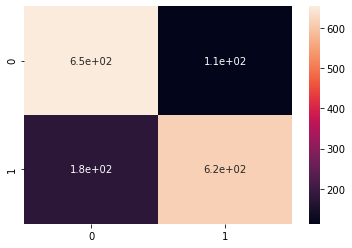

In [406]:
#test the model
test2=rf_clf.predict(testX)
print(accuracy_score(testy, test2))

#Confusion matrix
cm=confusion_matrix(testy,test2)
print(cm)
sns.heatmap(cm,annot=True)

print(classification_report(testy, test2))

### Decision Tree

0.828094932649134
[[654 113]
 [155 637]]
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       767
           1       0.85      0.80      0.83       792

    accuracy                           0.83      1559
   macro avg       0.83      0.83      0.83      1559
weighted avg       0.83      0.83      0.83      1559



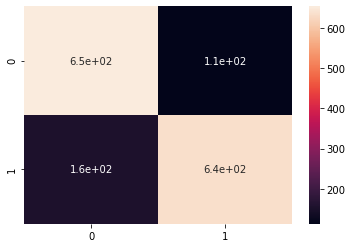

In [407]:
#test the model
test3=tree_clf.predict(testX)
print(accuracy_score(testy, test3))

#Confusion matrix
cm=confusion_matrix(testy,test3)
print(cm)
sns.heatmap(cm,annot=True)

print(classification_report(testy, test3))

### Logistic regression

0.7241821680564464
[[566 201]
 [229 563]]
              precision    recall  f1-score   support

           0       0.71      0.74      0.72       767
           1       0.74      0.71      0.72       792

    accuracy                           0.72      1559
   macro avg       0.72      0.72      0.72      1559
weighted avg       0.72      0.72      0.72      1559



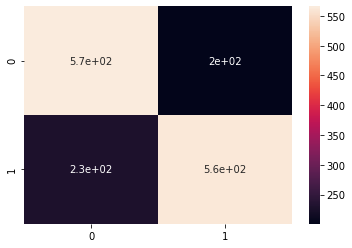

In [408]:
#test the model
test4=lr_clf.predict(testX)
print(accuracy_score(testy, test4))

#Confusion matrix
cm=confusion_matrix(testy,test4)
print(cm)
sns.heatmap(cm,annot=True)

print(classification_report(testy, test4))

### XGBoost

0.8992944194996793
[[714  53]
 [104 688]]
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       767
           1       0.93      0.87      0.90       792

    accuracy                           0.90      1559
   macro avg       0.90      0.90      0.90      1559
weighted avg       0.90      0.90      0.90      1559



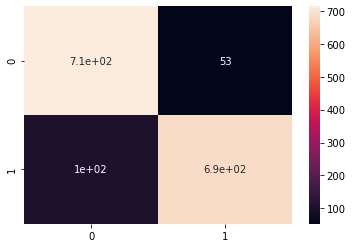

In [409]:
#test the model
test5=xgb_clf.predict(testX)
print(accuracy_score(testy, test5))

#Confusion matrix
cm=confusion_matrix(testy,test5)
print(cm)
sns.heatmap(cm,annot=True)

print(classification_report(testy, test5))

### SVM

0.8986529826812059
[[661 106]
 [ 52 740]]
              precision    recall  f1-score   support

           0       0.93      0.86      0.89       767
           1       0.87      0.93      0.90       792

    accuracy                           0.90      1559
   macro avg       0.90      0.90      0.90      1559
weighted avg       0.90      0.90      0.90      1559



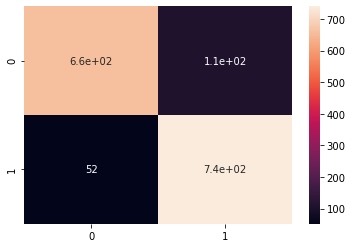

In [410]:
#test the model
test6=svc_clf.predict(testX)
print(accuracy_score(testy, test6))

#Confusion matrix
cm=confusion_matrix(testy,test6)
print(cm)
sns.heatmap(cm,annot=True)

print(classification_report(testy, test6))

## ROC Curve Comparision 

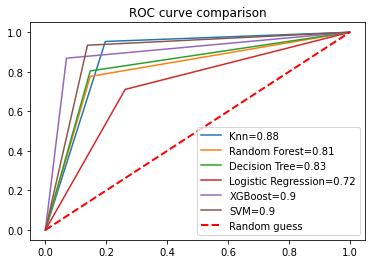

In [411]:
plt.figure().clf()
fpr, tpr,_ = metrics.roc_curve(testy, test1)
auc = metrics.roc_auc_score(testy, test1)
plt.plot(fpr,tpr,label="Knn="+str(round(auc,2)))
fpr, tpr,_ = metrics.roc_curve(testy, test2)
auc = metrics.roc_auc_score(testy, test2)
plt.plot(fpr,tpr,label="Random Forest="+str(round(auc,2)))
fpr, tpr,_ = metrics.roc_curve(testy, test3)
auc = metrics.roc_auc_score(testy, test3)
plt.plot(fpr,tpr,label="Decision Tree="+str(round(auc,2)))
fpr, tpr,_ = metrics.roc_curve(testy, test4)
auc = metrics.roc_auc_score(testy, test4)
plt.plot(fpr,tpr,label="Logistic Regression="+str(round(auc,2)))
fpr, tpr,_ = metrics.roc_curve(testy, test5)
auc = metrics.roc_auc_score(testy, test5)
plt.plot(fpr,tpr,label="XGBoost="+str(round(auc,2)))
fpr, tpr,_ = metrics.roc_curve(testy, test6)
auc = metrics.roc_auc_score(testy, test6)
plt.plot(fpr,tpr,label="SVM="+str(round(auc,2)))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
plt.title("ROC curve comparison")
plt.legend(loc=0)

### Important features of the best model (XG-Boost)

Text(0.5, 1.0, 'Feature Importance Ranking Related to The Best Model (XG-Boost)')

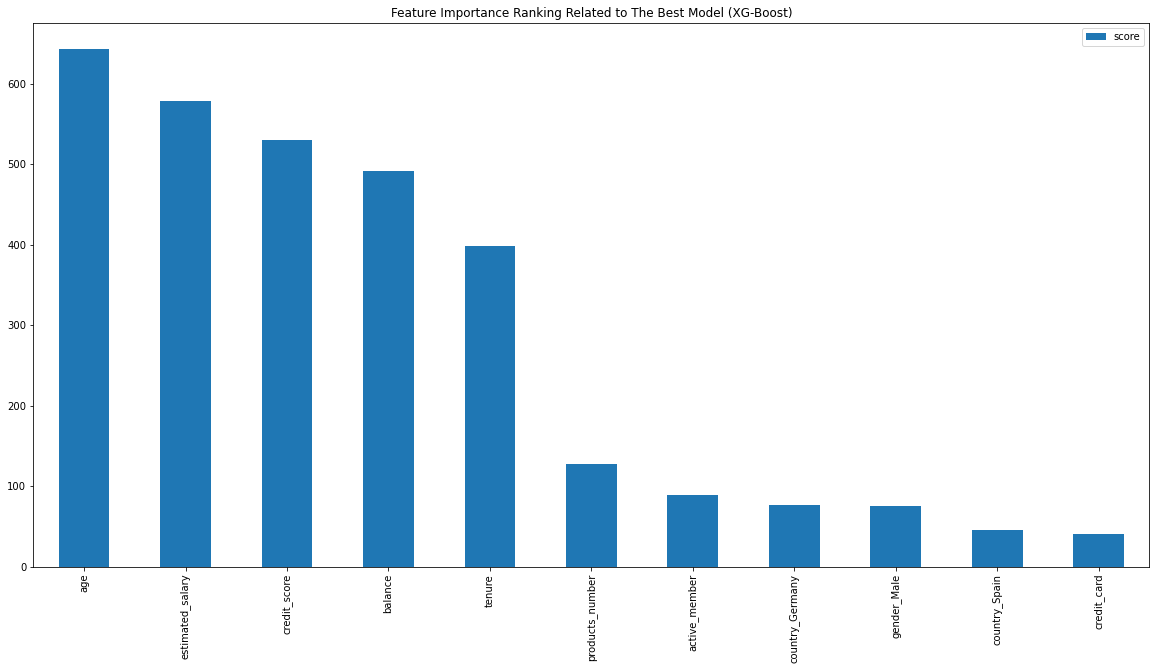

In [412]:
# fit the XGBoost model using the best parameters
best_clf=xgb.XGBClassifier(max_depth=6,n_estimators=100)
best_clf.fit(trainX,trainy)
feature_important = best_clf.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='bar', figsize = (20,10)) ## plot top 40 features
plt.title('Feature Importance Ranking Related to The Best Model (XG-Boost)')